# Simple Trading Rule

In [37]:
from sysdata.csvdata import csvFuturesData
import matplotlib.pyplot as plt
%matplotlib inline

Work up a minimum example of a trend following system

Let's get some data

We can get data from various places; however for now we're going to use
prepackaged 'legacy' data stored in csv files

In [8]:
data = csvFuturesData()
data


FuturesData object with 38 instruments

We get stuff out of data with methods

In [9]:
print(data.get_instrument_list())
print(data.get_raw_price("EDOLLAR").tail(5))

['CORN', 'LEANHOG', 'LIVECOW', 'SOYBEAN', 'WHEAT', 'KR10', 'KR3', 'BOBL', 'BTP', 'BUND', 'OAT', 'SHATZ', 'US10', 'US2', 'US20', 'US5', 'V2X', 'VIX', 'KOSPI', 'AEX', 'CAC', 'SMI', 'NASDAQ', 'SP500', 'AUD', 'EUR', 'GBP', 'JPY', 'MXP', 'NZD', 'COPPER', 'GOLD', 'PALLAD', 'PLAT', 'CRUDE_W', 'GAS_US', 'EDOLLAR', 'EUROSTX']
2016-11-07    98.5600
2016-11-08    98.5100
2016-11-09    98.2950
2016-11-10    98.1600
2016-11-11    98.1175
Name: price, dtype: float64


data can also behave in a dict like manner (though it's not a dict)

In [27]:
data['SP500']

1997-09-10    1047.6725
1997-09-11    1040.6725
1997-09-12    1056.6725
1997-09-15    1054.6725
1997-09-16    1078.6725
1997-09-17    1078.6725
1997-09-18    1080.6725
1997-09-19    1083.6725
1997-09-22    1088.6725
1997-09-23    1084.6725
1997-09-24    1077.6725
1997-09-25    1069.6725
1997-09-26    1075.6725
1997-09-29    1084.6725
1997-09-30    1076.6725
1997-10-01    1086.6725
1997-10-02    1091.6725
1997-10-03    1097.6725
1997-10-06    1104.6725
1997-10-07    1112.6725
1997-10-08    1105.6725
1997-10-09    1100.6725
1997-10-10    1099.6725
1997-10-13    1098.6725
1997-10-14    1099.6725
1997-10-15    1096.6725
1997-10-16    1082.6725
1997-10-17    1071.6725
1997-10-20    1085.6725
1997-10-21    1101.6725
                ...    
2016-10-03    2153.5000
2016-10-04    2144.7500
2016-10-05    2153.5000
2016-10-06    2156.5000
2016-10-07    2146.5000
2016-10-10    2159.2500
2016-10-11    2134.5000
2016-10-12    2131.5000
2016-10-13    2126.5000
2016-10-14    2127.0000
2016-10-17    21

In [28]:
data.keys()

['CORN',
 'LEANHOG',
 'LIVECOW',
 'SOYBEAN',
 'WHEAT',
 'KR10',
 'KR3',
 'BOBL',
 'BTP',
 'BUND',
 'OAT',
 'SHATZ',
 'US10',
 'US2',
 'US20',
 'US5',
 'V2X',
 'VIX',
 'KOSPI',
 'AEX',
 'CAC',
 'SMI',
 'NASDAQ',
 'SP500',
 'AUD',
 'EUR',
 'GBP',
 'JPY',
 'MXP',
 'NZD',
 'COPPER',
 'GOLD',
 'PALLAD',
 'PLAT',
 'CRUDE_W',
 'GAS_US',
 'EDOLLAR',
 'EUROSTX']

... however this will only access prices
(note these prices have already been backadjusted for rolls)

We have extra futures data here

In [29]:
data.get_instrument_raw_carry_data("EDOLLAR").tail(6)

,PRICE,CARRY,CARRY_CONTRACT,PRICE_CONTRACT
2016-11-04,98.6250,98.675,201906,201909
2016-11-07,98.5600,98.610,201906,201909
2016-11-08,98.5100,98.565,201906,201909
2016-11-09,98.2950,98.365,201906,201909
2016-11-10,98.1600,98.230,201906,201909
2016-11-11,98.1175,NaN,201906,201909


Technical note: csvFuturesData inherits from FuturesData which itself inherits
from Data
The chain is 'data specific' <- 'asset class specific' <- 'generic'

So there are also

In principal there could be an equities data

Let's create a simple trading rule

No capping or scaling

In [13]:
import pandas as pd
from syscore.algos import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading fule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # http://qoppac.blogspot.co.uk/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


Try it out

(this isn't properly scaled at this stage of course)


In [38]:
instrument_code = 'EDOLLAR'
price = data.daily_prices(instrument_code)
ewmac = calc_ewmac_forecast(price, 32, 128)
ewmac.columns = ['forecast']
ewmac.tail(5)


2016-11-07    0.100716
2016-11-08   -0.011247
2016-11-09   -0.237658
2016-11-10   -0.513974
2016-11-11   -0.835147
Freq: B, dtype: float64

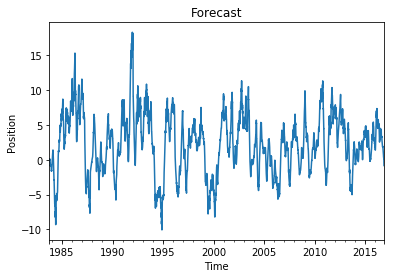

In [39]:
ewmac.plot();
plt.title('Forecast')
plt.ylabel('Position')
plt.xlabel('Time')


Did we make money?


In [45]:
accountCurve?

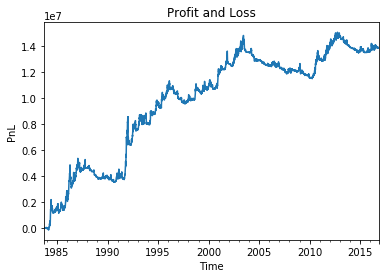

In [48]:
from syscore.accounting import accountCurve
account = accountCurve(price, forecast=ewmac)
account.curve().plot();
plt.title('Profit and Loss')
plt.ylabel('PnL')
plt.xlabel('Time');

In [24]:
account.percent().stats()

[[('min', '-7.911'),
  ('max', '5.22'),
  ('median', '0'),
  ('mean', '0.01602'),
  ('std', '0.515'),
  ('skew', '-0.5705'),
  ('ann_mean', '4.102'),
  ('ann_std', '8.24'),
  ('sharpe', '0.4978'),
  ('sortino', '0.5583'),
  ('avg_drawdown', '-11.93'),
  ('time_in_drawdown', '0.9735'),
  ('calmar', '0.1237'),
  ('avg_return_to_drawdown', '0.3439'),
  ('avg_loss', '-0.3289'),
  ('avg_gain', '0.3399'),
  ('gaintolossratio', '1.033'),
  ('profitfactor', '1.118'),
  ('hitrate', '0.5195'),
  ('t_stat', '2.891'),
  ('p_value', '0.003851')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent', 'cumulative'])]